<p style="font-size:14pt;text-align:center;">
Train YOLO network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys
import simplejson

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
from lasagne import nonlinearities
from lasagne import layers
    
import bnr_ml.objectdetect.yolo as yolo
from bnr_ml.objectdetect import utils

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.json', 'r') as f:
    annotations = simplejson.load(f)

In [3]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for a in annotations:
        for obj in a['annotations']:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [4]:
def fix_labels(annotations):
    for a in annotations:
        a['image'] = '/usr/local/python/bnr_ml/data/PascalVOC/' + a['image']
        new_objs = []
        for obj in a['annotations']:
            lab = obj['label'].lower()
            if 'car' in lab:
                lab = 'car'
            elif 'person' in lab:
                lab = 'person'
            elif 'bike' in lab:
                lab = 'bike'
            elif 'bicycle' in lab:
                lab = 'bicycle'
            else:
                lab = None
                
            if lab != None:
                obj['label'] = lab
                new_objs.append(obj)
        a['annotations'] = new_objs
    return annotations

In [5]:
annotations = np.asarray(fix_labels(annotations))

In [6]:
counts = get_label_counts(annotations)

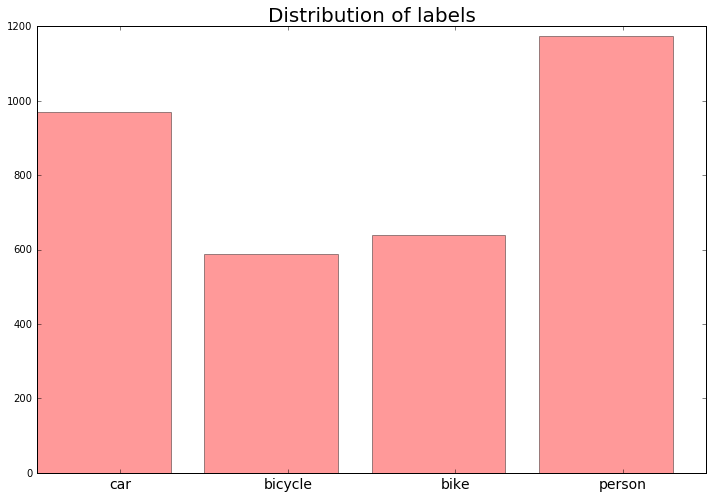

In [7]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [8]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [9]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [10]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [253]:
def generate_data_2(annotations, C, max_objs=15, size=(200,200), batch_size=100):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size).swapaxes(2,1).swapaxes(1,0)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] = np.float_(coord[[0,2]]) / old_size[1]
        coord[[1,3]] = np.float_(coord[[1,3]]) / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        
        coord[[2,3]] = np.log(coord[[1,3]])
        
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
#     annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for i in range(0,annotations.shape[0], batch_size):
        Xbatch = np.zeros((batch_size,3) + size)
        ybatch = np.zeros((batch_size, (4 + C) * max_objs))
        
        for j in range(min(batch_size, annotations.shape[0] - i)):
            annotation = annotations[i+j]
            objs = annotation['annotations']
            im = imread(annotation['image'])
            old_size = np.float_(annotation['size'])
            
            Xbatch[j] = reformat_image(im, size)
            
            for k in range(max_objs):
                if k < objs.__len__():
                    obj = objs[k]
                    coord = np.asarray([
                            obj['x'],
                            obj['y'],
                            obj['w'],
                            obj['h']
                        ], dtype=theano.config.floatX)
                    coord = transform_coord(coord, old_size, size)
                    ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                    ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                else:
                    ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth
            
        yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [245]:
def generate_data_3(annotations, C, max_objs=15, size=(200,200), batch_size=100, augment=10):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for num in range(augment):
        for i in range(0,annotations.size, batch_size):
            Xbatch = np.zeros((batch_size,3) + size)
            ybatch = np.zeros((batch_size, (4 + C) * max_objs))

            for j in range(min(batch_size, annotations.size - i)):
                objs = annotations[i+j][annotations]
                im = imread(annotations[i+j]['image'])
                old_size = im.shape
                
                old_box = Box(0.,0.,1.,1.)
                iterlap = .8
                new_width = iterlap + (1. - iterlap) * np.random.rand()
                new_height = iterlap +  (1. - iterlap) * np.random.rand()
                new_xi = (1. - new_width) * np.random.rand()
                new_yi = (1. - new_height) * np.random.rand()
                new_box = Box(
                    new_xi,
                    new_yi,
                    new_width + new_xi,
                    new_height + new_yi
                )
                im = new_box.subimage(im)

                im = reformat_image(im, size)
                
                im = rgb2hsv(im)
                im[:,:,[0,2]] *= (1 + .1 * np.random.rand(1,1,2))
                im = hsv2rgb(im)
                
                Xbatch[j] = im.swapaxes(2,1).swapaxes(1,0)

                for k in range(max_objs):
                    if k < objs.__len__():
                        obj = objs[k]
                        coord = np.asarray([
                                obj['x'],
                                obj['y'],
                                obj['w'],
                                obj['h']
                            ])
#                         coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                        coord = transform_coord(coord, old_size, size)
                        
                        obj_box = Box(coord[0], coord[1], coord[0] + coord[2], coord[1] + coord[3])
                        
                        if new_box.iou(obj_box) > 0.5:
                            coord[0] -= new_box.xi
                            coord[1] -= new_box.yi
                            coord[[0,2]] /= (new_box.xf - new_box.xi)
                            coord[[1,3]] /= (new_box.yf - new_box.yi)
                            ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                            ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                        else:
                            ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

                    else:
                        ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

            yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [246]:
def generate_data(annotations, C, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + C))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [181]:
S = (5,5)
B = 2
C = 4

In [186]:
num_epochs = 1000
batch_size = 10
input_shape = (224,224)

In [310]:
test_net = True
if test_net:
    Xtest, ytest = [t for t in generate_data_2(train_annotations[[600]], C, batch_size=batch_size, size=input_shape)][0]
    Xtest, ytest = theano.shared(Xtest), theano.shared(ytest)
    input_var = Xtest
else:
    input_var=None

In [311]:
import lasagne.nonlinearities as nonlinearities

In [312]:
net = {}
net['input'] = InputLayer((None, 3) + input_shape, input_var=input_var)
net['conv1_1'] = Conv2DLayer(net['input'], 64, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv1_2'] = Conv2DLayer(net['conv1_1'], 64, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool1'] = Pool2DLayer(net['conv1_2'], 2)
net['conv2_1'] = Conv2DLayer( net['pool1'], 128, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv2_2'] = Conv2DLayer(net['conv2_1'], 128, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool2'] = Pool2DLayer(net['conv2_2'], 2)
net['conv3_1'] = Conv2DLayer(net['pool2'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv3_2'] = Conv2DLayer(net['conv3_1'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv3_3'] = Conv2DLayer(net['conv3_2'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool3'] = Pool2DLayer(net['conv3_3'], 2)
net['conv4_1'] = Conv2DLayer(net['pool3'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv4_2'] = Conv2DLayer(net['conv4_1'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv4_3'] = Conv2DLayer(net['conv4_2'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool4'] = Pool2DLayer(net['conv4_3'], 2)
net['conv5_1'] = Conv2DLayer(net['pool4'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv5_2'] = Conv2DLayer(net['conv5_1'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv5_3'] = Conv2DLayer(net['conv5_2'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool5'] = Pool2DLayer(net['conv5_3'], 2)
net['fc6'] = DenseLayer(net['pool5'], num_units=2048, nonlinearity=None)
net['fc6_dropout'] = dropout(net['fc6'], p=0)
net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=2048, nonlinearity=None)
net['fc7_dropout'] = dropout(net['fc7'], p=0)
# net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
# net['prob'] = NonlinearityLayer(net['fc8'], nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [238]:
load_pretrained = True
if load_pretrained:
    with open('/usr/local/python/bnr_ml/data/pretrained/vgg16.pkl', 'rb') as f:
        weights = pk.load(f)['param values']
        lasagne.layers.set_all_param_values(net['conv5_3'], weights[:-6])

<b>Add extra layers to network for detection</b>

In [313]:
net['fc6'] = DenseLayer(net['pool5'], 2048, nonlinearity=None)
net['output'] = DenseLayer(dropout(net['fc6'], p=0), (B * (C + 1) + 4) * (S[0] * S[1]), nonlinearity=None)
# net['output'] = DenseLayer(dropout(net['dense1'], p=.0), (B * 5 + C) * S[0]*S[1])

In [314]:
load_weights = True
if load_weights:
    with open('tmp.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [315]:
import bnr_ml.utils.nonlinearities as nonlinearities

In [319]:
reload(nonlinearities)
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [320]:
yl = yolo.YoloObjectDetector(net, (None, 3) + input_shape, C, S, B) 

In [321]:
gen_fn = lambda ann, shape, batch_size: generate_data_2(ann, C, size=shape, batch_size=batch_size)

In [ ]:
cost = yl._get_cost(yl.output, ytest, S, B, C)

> /usr/local/python/bnr_ml/objectdetect/yolo.py(257)_get_cost()
-> return cost, [iou, obj_in_cell_and_resp, conf_is_zero, obj_in_cell_and_resp, cell_intersects]
(Pdb) cost.eval()
array(0.0026371136773377657)


In [294]:
train_loss, test_loss = yl.train(
    gen_fn,
    train_annotations[[600]],
    test_annotations[:1],
    lr=1e-6,
    epochs=4000
)

Getting cost...
Creating cost variable took 0.7915 seconds
Compiling...


  0%|          | 0/4000 [00:00<?, ?it/s]

Compiling functions took 32.5768 seconds
Beginning training...
0.00465690530837


  0%|          | 1/4000 [00:03<3:49:15,  3.44s/it]

Epoch 0
------
Train Loss: 0.0047, Test Loss: 2.3792
0.00450296327472


  0%|          | 2/4000 [00:06<3:47:49,  3.42s/it]

Epoch 1
------
Train Loss: 0.0045, Test Loss: 2.3692
0.00435908511281


  0%|          | 3/4000 [00:10<3:46:43,  3.40s/it]

Epoch 2
------
Train Loss: 0.0044, Test Loss: 2.3595
0.00422434695065


  0%|          | 4/4000 [00:13<3:46:05,  3.39s/it]

Epoch 3
------
Train Loss: 0.0042, Test Loss: 2.3502
0.00409755762666


  0%|          | 5/4000 [00:16<3:45:30,  3.39s/it]

Epoch 4
------
Train Loss: 0.0041, Test Loss: 2.3412
0.00397799257189


  0%|          | 6/4000 [00:20<3:45:17,  3.38s/it]

Epoch 5
------
Train Loss: 0.0040, Test Loss: 2.3325
0.0038651979994


  0%|          | 7/4000 [00:23<3:45:07,  3.38s/it]

Epoch 6
------
Train Loss: 0.0039, Test Loss: 2.3240
0.00375873525627


  0%|          | 8/4000 [00:27<3:44:49,  3.38s/it]

Epoch 7
------
Train Loss: 0.0038, Test Loss: 2.3158
0.00365764042363


  0%|          | 9/4000 [00:30<3:44:39,  3.38s/it]

Epoch 8
------
Train Loss: 0.0037, Test Loss: 2.3078
0.00356175377965


  0%|          | 10/4000 [00:33<3:44:37,  3.38s/it]

Epoch 9
------
Train Loss: 0.0036, Test Loss: 2.3000
0.0034703745041


  0%|          | 11/4000 [00:37<3:44:30,  3.38s/it]

Epoch 10
------
Train Loss: 0.0035, Test Loss: 2.2925
0.00338333076797


  0%|          | 12/4000 [00:40<3:44:32,  3.38s/it]

Epoch 11
------
Train Loss: 0.0034, Test Loss: 2.2851
0.00330009381287


  0%|          | 13/4000 [00:43<3:44:30,  3.38s/it]

Epoch 12
------
Train Loss: 0.0033, Test Loss: 2.2779
0.0032206682954


  0%|          | 14/4000 [00:47<3:44:32,  3.38s/it]

Epoch 13
------
Train Loss: 0.0032, Test Loss: 2.2709
0.00314473733306


  0%|          | 15/4000 [00:50<3:44:27,  3.38s/it]

Epoch 14
------
Train Loss: 0.0031, Test Loss: 2.2640
0.00307197519578


  0%|          | 16/4000 [00:54<3:44:21,  3.38s/it]

Epoch 15
------
Train Loss: 0.0031, Test Loss: 2.2573
0.00300217000768


  0%|          | 17/4000 [00:57<3:44:10,  3.38s/it]

Epoch 16
------
Train Loss: 0.0030, Test Loss: 2.2508
0.00293510500342


  0%|          | 18/4000 [01:00<3:44:08,  3.38s/it]

Epoch 17
------
Train Loss: 0.0029, Test Loss: 2.2443
0.00287070614286


  0%|          | 19/4000 [01:04<3:44:07,  3.38s/it]

Epoch 18
------
Train Loss: 0.0029, Test Loss: 2.2381
0.00280881021172


  0%|          | 20/4000 [01:07<3:43:59,  3.38s/it]

Epoch 19
------
Train Loss: 0.0028, Test Loss: 2.2319
0.00274934177287


  1%|          | 21/4000 [01:10<3:44:05,  3.38s/it]

Epoch 20
------
Train Loss: 0.0027, Test Loss: 2.2259
0.0026921920944


  1%|          | 22/4000 [01:14<3:44:14,  3.38s/it]

Epoch 21
------
Train Loss: 0.0027, Test Loss: 2.2201


In [309]:
with open('tmp.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [251]:
concat_loss = False
if concat_loss:
    train_loss_total = np.concatenate((train_loss_total, train_loss))
    test_loss_total = np.concatenate((test_loss_total, test_loss))
else:
    train_loss_total, test_loss_total = train_loss, test_loss

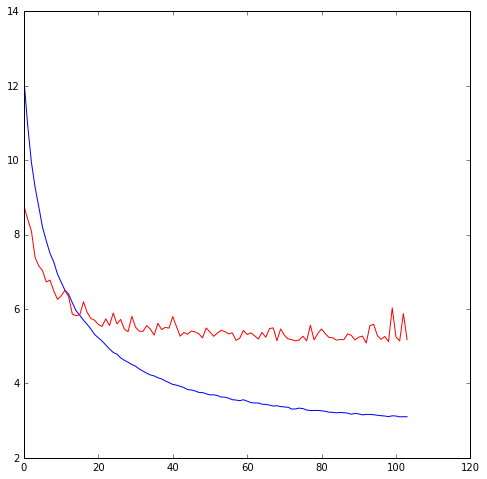

In [252]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx], 'b')
plt.plot(test_loss_total[idx], 'r')

In [266]:
def get_label_from_num(num):
    if num == 0:
        return 'car'
    elif num == 1:
        return 'bicycle'
    elif num == 2:
        return 'bike'
    elif num == 3:
        return 'person'

In [267]:
swap = lambda im: im.swapaxes(0,1).swapaxes(1,2)

In [295]:
gen = generate_data_2(train_annotations[[600]], C, max_objs=5, size=input_shape)

In [296]:
testdat = [t for t in gen]

In [297]:
Xtest, ytest = testdat[0]

In [298]:
print np.round(100*ytest)/100

[[  0.22         0.06        -2.76999998  -3.69000006   0.           0.
    0.           1.           0.67000002   0.01        -4.55999994
   -1.01999998   0.           0.           0.           1.           0.80000001
    0.          -6.17000008  -0.95999998   0.           0.           0.
    1.         -10.         -10.           0.01         0.01         0.
    0.           0.           0.         -10.         -10.           0.01
    0.01         0.           0.           0.           0.        ]]


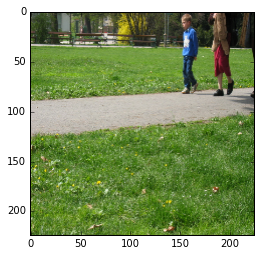

In [299]:
plt.imshow(swap(Xtest[0]))

In [300]:
out_fn = theano.function([yl.input], yl.output_test)

In [301]:
Xtest_out = out_fn(Xtest[:])

In [303]:
Xtest_out.shape

(1, 14, 5, 5)

In [302]:
np.round(100 * Xtest_out[0,:,3,2]) / 100

array([-2.18000007, -2.08999991, -0.73000002, -2.92000008,  0.        ,
        1.26999998, -6.05000019,  0.44      ,  1.24000001,  0.01      ,
        0.2       ,  0.73000002,  0.04      ,  0.03      ], dtype=float32)

In [276]:
N = int(np.random.rand() * Xtest_out.shape[0])
print N

0


In [304]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [305]:
coords = yolo.YoloObjectDetector.nms(Xtest_out[N], S, B, C, thresh=.01, overlap=.05)
print coords.shape

> /usr/local/python/bnr_ml/objectdetect/yolo.py(360)nms()
-> preds = []
(Pdb) scores_flat
array([ 0.01079543,  0.00612976,  0.00698533,  0.00532636,  0.00442079,
        0.00339387,  0.00550903,  0.00723795,  0.00822864,  0.00605772,
        0.00992587,  0.0034461 ,  0.00769498,  0.00678635,  0.00751616,
        0.00344876,  0.006353  ,  0.00340987,  0.01098675,  0.00761619,
        0.006319  ,  0.00398761,  0.00258196,  0.00463825,  0.00696827,
        0.01002004,  0.00580436,  0.00742614,  0.00470908,  0.00428675,
        0.00410412,  0.00629864,  0.00778978,  0.00684401,  0.00468427,
        0.00979613,  0.00531718,  0.00990075,  0.00606449,  0.00712208,
        0.00266608,  0.00639796,  0.00706506,  0.00858453,  0.0066996 ,
        0.00557897,  0.00411223,  0.00396812,  0.00440624,  0.00635474], dtype=float32)
(Pdb) np.max(scores_flat)
0.010986751
(Pdb) n
> /usr/local/python/bnr_ml/objectdetect/yolo.py(361)nms()
-> for i in range(above_thresh_idx.size):
(Pdb) c
(2, 6)


In [306]:
coords

array([[-0.81815374, -1.39845562,  3.28814583,  1.87478418,  0.01079543,
         0.        ],
       [-0.61270261,  1.23412848,  1.90733995,  0.25037173,  0.01098675,
         3.        ]])

In [307]:
im = utils.draw_coord(swap(Xtest[N]), coords, get_label_from_num)

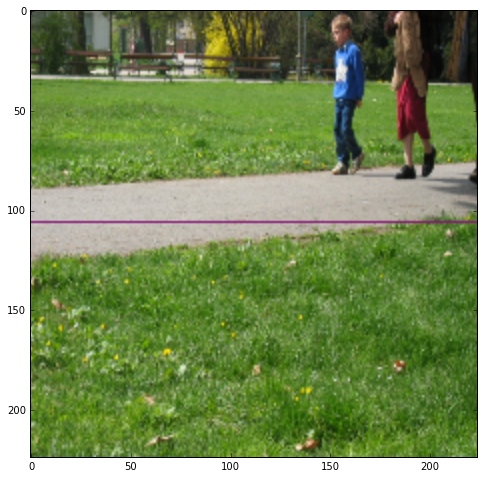

In [308]:
plt.figure(figsize=(8,8))
plt.imshow(im)

In [292]:
pred = np.copy(Xtest_out[N])
score = pred[[4,9]] * pred[-C:].max(keepdims=True)
score = score.flatten()
args = score.argsort()[::-1][:10]
preds = []
for i in range(args.size):
    idx = np.unravel_index(args[i], pred[[4,9]].shape)
    crd = pred[5*idx[0]:5*idx[0] + 4,idx[1], idx[2]]
    tmp = crd[[2,3]]
    tmp[tmp<1] = 0.5*tmp[tmp<1]**2
    tmp[tmp>=1] = np.abs(tmp[tmp>=1]) - 0.5
    crd[[2,3]] = tmp
    crd = crd.tolist()
    crd[0], crd[1] = crd[0] + np.float_(idx[2]) /S[1], crd[1] + np.float_(idx[1]) / S[0]
    crd.append(score[args[i]])
    preds.append(crd)
preds = np.asarray(preds)

In [ ]:
nms(preds, .3)

In [ ]:
plt.imshow(draw_coord(swap(Xtest[N]), nms(preds, .3)[0], None))

In [ ]:
tmp = np.arange()

In [ ]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [ ]:
N = int(Xtest.shape[0] * np.random.rand())
print N
a, b = draw_best(swap(Xtest[N]), Xtest_out[N], num = 5, thresh=.2)

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(a)
print b
# print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
# print c
# print d

In [ ]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [ ]:
im2 = rgb2hsv(im)

In [ ]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [ ]:
im3 = hsv2rgb(im2)